In [ ]:
# Import Library
import os
import pandas as pd
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import zipfile
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.resnet50 import preprocess_input

Using TensorFlow backend.


In [ ]:
#@title Helpers Function
def gen_label(directory):
    label = []
    for file in os.listdir(directory):
        if (file.split('.')[0] == 'dog'):
            label.append(str(1))
        elif (file.split('.')[0] == 'cat'):
            label.append(str(0))
    return label
    #print(len(label),"files in", directory)
    
def get_path(directory): #function to generate a list of files' names
    path = []
    for files in os.listdir(directory):
        if '.ipynb_checkpoints' not in files:
            path.append(files)
        else:
            pass
    return path

# Load Data and EDA

In [ ]:
train_y = gen_label('/home/jupyter/train/cat')
train_y.extend(gen_label('/home/jupyter/train/dog'))

In [ ]:
train_cats = get_path('/home/jupyter/train/cat')
train_dogs = get_path('/home/jupyter/train/dog')
train_dog = []
train_cat = []
categories = []
for i in train_dogs:
    a= './dog/'+i
    train_dog.append(a)
for i in train_cats:
    a= './cat/'+i
    train_cat.append(a)
train_cat.extend(train_dog)

             filename category
0  ./cat/cat.6259.jpg        0
1  ./cat/cat.8290.jpg        0
2   ./cat/cat.765.jpg        0
3  ./cat/cat.3733.jpg        0
4  ./cat/cat.8455.jpg        0


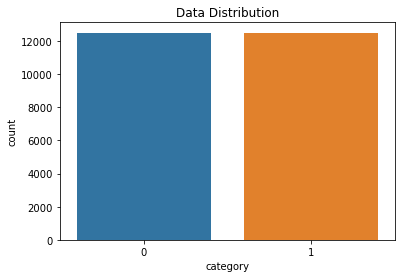

In [ ]:
# EDA
df = pd.DataFrame({'filename': train_cat,
                  'category': train_y})
print(df.head())

sns.countplot(x='category',data=df).set_title("Data Distribution")
plt.show()

In [ ]:
#instantiate the constants
batch_size = 128
img_size = 224
epochs = 5

# Create train and Test set
  

In [ ]:
# Split Train, Test set
train_df1, valid_df1 = train_test_split(df, test_size=0.25)
print(train_df1.shape)
print(valid_df1.shape)

(18750, 2)
(6250, 2)


In [ ]:
train_df1['filename'].value_counts()

./cat/cat.10122.jpg    1
./dog/dog.2533.jpg     1
./cat/cat.6497.jpg     1
./cat/cat.12108.jpg    1
./cat/cat.9905.jpg     1
                      ..
./cat/cat.4186.jpg     1
./dog/dog.5252.jpg     1
./dog/dog.2789.jpg     1
./dog/dog.8472.jpg     1
./dog/dog.9658.jpg     1
Name: filename, Length: 18750, dtype: int64

In [ ]:
import numpy as np 
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
points = os.listdir('./cat')
dogs = os.listdir('./dog')
dog = []
cat = []
categories = []
for i in dogs:
    a= './dog/'+i
    dog.append(a)
for i in points:
    a= './cat/'+i
    cat.append(a)
cat.extend(dog)

In [ ]:
for point in cat:
    category = point.split('/')[1]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
    
df = pd.DataFrame({'point': cat,
                   'category': categories})


In [ ]:
# Define Constant
FAST_RUN = False
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [ ]:
# Data Preprocess
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [ ]:
# EDA
train_df.shape

(20000, 2)

In [ ]:
# Create Generator
train_df["category"] = train_df["category"].replace({0: '0', 1: '1'}) 
validate_df["category"] = validate_df["category"].replace({0: '0', 1: '1'}) 
batch_size=32

from keras.applications.mobilenet_v2 import preprocess_input
train_datagen = ImageDataGenerator(
    rotation_range= 30,
    rescale= 1./255,
    shear_range= 0.1,
    zoom_range= 0.2,
    horizontal_flip= True, 
    width_shift_range= 0.2,
    height_shift_range= 0.2
    # preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    directory=None, 
    x_col='point',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.


In [ ]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
    )

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    directory=None, 
    x_col='point',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


# Train Model

In [ ]:
import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [ ]:
# Define model
from tensorflow.keras import regularizers

def define_model():
    # load model
    model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(224, 224, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(50, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = tf.keras.Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = tf.keras.optimizers.RMSprop(lr=0.001, momentum=0.9)
    sgd = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9) # Increase momentum to 0.9
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = define_model()

In [ ]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)
callbacks = [earlystop, learning_rate_reduction]

In [ ]:
epochs=20
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples//batch_size,
    steps_per_epoch=train_generator.samples//batch_size,
    callbacks=callbacks
)

Epoch 1/20
625/625 [==============================] - 270s 432ms/step - loss: 0.1315 - accuracy: 0.9456 - val_loss: 0.0699 - val_accuracy: 0.9780 - lr: 0.0100
Epoch 2/20
625/625 [==============================] - 268s 430ms/step - loss: 0.1132 - accuracy: 0.9563 - val_loss: 0.0596 - val_accuracy: 0.9798 - lr: 0.0100
Epoch 3/20
625/625 [==============================] - 268s 429ms/step - loss: 0.0964 - accuracy: 0.9617 - val_loss: 0.0625 - val_accuracy: 0.9782 - lr: 0.0100
Epoch 4/20
625/625 [==============================] - ETA: 0s - loss: 0.0967 - accuracy: 0.9635
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
625/625 [==============================] - 268s 429ms/step - loss: 0.0967 - accuracy: 0.9635 - val_loss: 0.0552 - val_accuracy: 0.9788 - lr: 0.0100
Epoch 5/20
625/625 [==============================] - 268s 429ms/step - loss: 0.0809 - accuracy: 0.9672 - val_loss: 0.0467 - val_accuracy: 0.9820 - lr: 0.0050
Epoch 6/20
625/625 [=====================

# Save Model

In [ ]:
model.save('catdog_mobilenetv2_minh2.h5')